<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-ознакомление" data-toc-modified-id="Загрузка-и-ознакомление-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и ознакомление</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegression" data-toc-modified-id="CatBoostRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegression</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LtghtGBM" data-toc-modified-id="LtghtGBM-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LtghtGBM</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

**Описание проекта:**  

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.  

Значение метрики RMSE на тестовой выборке должно быть не больше 48.  

_Количество заказов находится в столбце 'num_orders'_

## Загрузка и ознакомление

In [1]:
!pip install catboost


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install lightgbm


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(r'C:\Users\79119\Desktop\DF\taxi\taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
def info_df(df):
    print('Ознакомление')
    display(df.head())
    print(' ')
    print('Информация')
    print(df.info())
    print(' ')
    print('Пропуски')
    print(df.isna().sum())
    print(' ')
    print('Проверка хронологического порядка')
    print(df.index.is_monotonic)

In [6]:
info_df(df)

Ознакомление


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


 
Информация
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
 
Пропуски
num_orders    0
dtype: int64
 
Проверка хронологического порядка
True


In [7]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [8]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

**Вывод:**    
Датасет состоит из 26496 строк и 2-ч столбцов, один из которых (datetime) мы преобразовали в индекс. Второй столбец типа int. Пропусков нет, хронологический порядок соблюден. Период за который паредоставлены данные с 01 марта 2018г. по 31 августа 2018г.

## Анализ

In [9]:
data = df.copy(deep=True)

Сгруппируем значения, просуммировав количество заказов за день и построим график по скользящему среднему

<AxesSubplot:xlabel='datetime'>

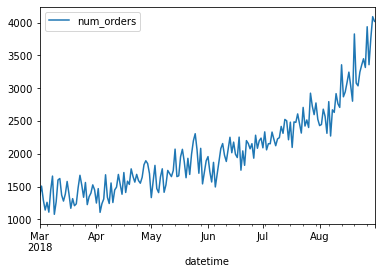

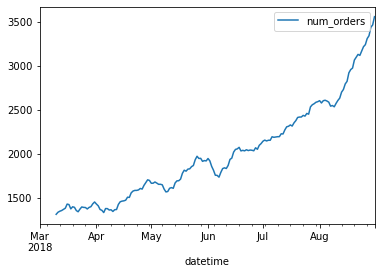

In [10]:
data = df.resample('1D').sum()
data.plot()
data.rolling(10).mean().plot()

Посмотрим тренд, сезонность и шум

In [11]:
decomposed = seasonal_decompose(data)

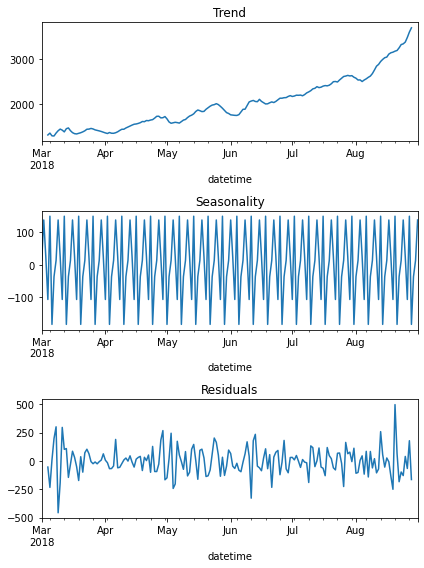

In [12]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд имеет тенденцию к росту. Присутствует недельная цикличность. Рассмотрим период в 1 месяц

<AxesSubplot:xlabel='datetime'>

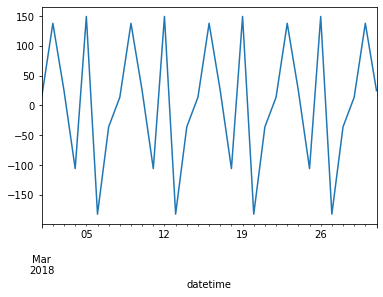

In [13]:
decomposed.seasonal['2018-03-01': '2018-03-31'].plot()

Пики приходятся на середину рабочей недели и на выходные. С воскресенья на понедельник достигается самый минимум по количеству заказов. Посмотрим, что происходит в течение дня.

<AxesSubplot:xlabel='datetime'>

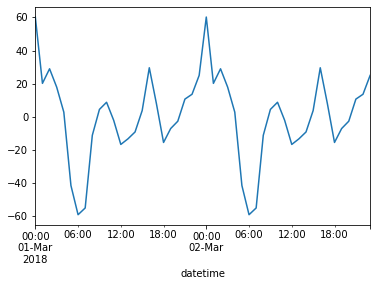

In [14]:
data_1 = df.resample('1H').sum()
decomposed_1 = seasonal_decompose(data_1)
decomposed_1.seasonal['2018-03-01': '2018-03-02'].plot()

С 7:00 начинается резкий рост(все едут на работу), второй пик приходится на середину дня и третий рост начинается с 18:00 и приходится на час пик. Максимум достигается в 00:00 часов (чем позднее, тем чаще пользуются услугами такси) и далее идет на спад до утра.

In [15]:
df_1 = data.copy()

Сделаем проверку ряда на стационарность

In [16]:
df_1 = df_1 - df_1.shift()

<AxesSubplot:xlabel='datetime'>

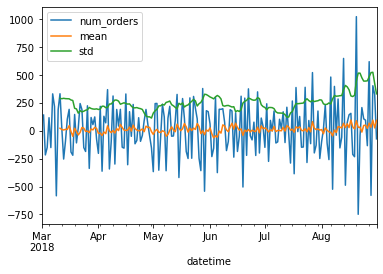

In [17]:
df_1['mean'] = df_1['num_orders'].rolling(10).mean()
df_1['std'] = df_1['num_orders'].rolling(10).std()
df_1.plot()

На графике скользящее среднее практически не меняется, а вот стандартное отклонение имеет тенденцию к росту начиная с августа. У стационарных рядов оба параметра должны оставаться неизменными. Сделаем проверку на стационарность тестом Дики-Фуллера

In [18]:
test = adfuller(data)
print('adf', test[0])
print('p-value', test[1])
print('Critical values', test[4])
if test[1]>test[4]['5%']:
    print('есть единичные корни, ряд нестационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf 3.728791311564993
p-value 1.0
Critical values {'1%': -3.469413468959902, '5%': -2.8786964197028295, '10%': -2.5759166089965397}
есть единичные корни, ряд нестационарен


Тест подтвердил гипотезу, что ряд нестационарен.

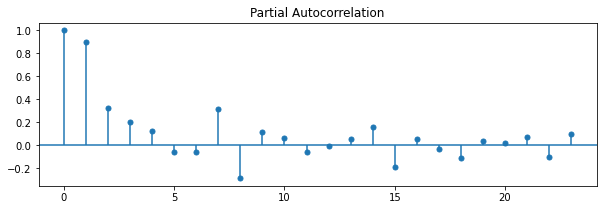

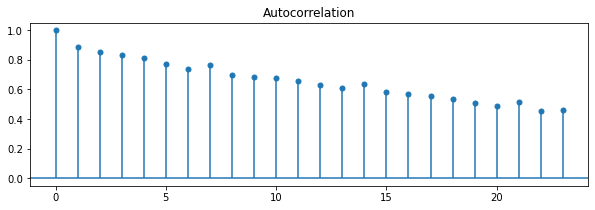

In [19]:
plot_pacf(data, alpha=None).set_size_inches(10, 3)
plt.show()

plot_acf(data, alpha=None).set_size_inches(10, 3)
plt.show()

**Вывод**  
1. Тренд ряда имеет тенденцию к росту  
2. Наблюдается еженедельная и ежедневная цикличность  
3. Проверка на тесте Дики-Фуллера показала нам, что ряд нестационарен.

## Обучение

### Подготовка данных

In [20]:
df_2 = df.copy()

Напишем функцию, которая будт добавлять признаки: день, день недели, час, лаги и скользящее среднее

In [21]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.resample('1H').sum()
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data


Задала количество лагов и ширину окна равным количеству точек. 

In [22]:
df_2 = make_features(df_2, 24, 24)

Удалим образовавшиеся пропуски

In [23]:
df_2 = df_2.dropna()

In [24]:
df_2.isna().sum().sum()

0

Подготовим данные для дальнейшего обучения моделей

In [25]:
train, test = train_test_split(df_2, test_size=0.1, shuffle=False)

In [26]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [27]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [28]:
print('Размер обучающей выборки', X_train.shape, y_train.shape)
print('Размер тестовой выборки', X_test.shape, y_test.shape)

Размер обучающей выборки (3952, 28) (3952,)
Размер тестовой выборки (440, 28) (440,)


In [29]:
X_train

,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 11:00:00,13,0,11,156.0,137.0,91.0,39.0,66.0,83.0,143.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,137.250000
2018-08-13 12:00:00,13,0,12,144.0,156.0,137.0,91.0,39.0,66.0,83.0,...,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,139.875000
2018-08-13 13:00:00,13,0,13,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,138.583333


Напишем функцию, которая подберет модель с наилучшим показателем RMSE

In [30]:
def grid(model, params, features, target):
    tscv = TimeSeriesSplit()
    grid = GridSearchCV(model, 
                         params,
                         n_jobs=-1,
                         scoring= 'neg_root_mean_squared_error', 
                         cv=tscv)
    grid.fit(features, target)
    return grid, grid.best_params_, grid.best_score_

### LinearRegression

In [31]:
tscv = TimeSeriesSplit()


In [32]:
cv_lr = cross_val_score(LinearRegression(),
                       X_train,
                       y_train,
                       scoring='neg_root_mean_squared_error',
                       cv=tscv).mean()

In [33]:
print(f'Значение RMSE линейной регрессии составляет {cv_lr*-1:.2f}')

Значение RMSE линейной регрессии составляет 27.15


### CatBoostRegression

In [34]:
params_cat = {"iterations": range(200, 500, 20),
              "depth": range(1, 10, 2),
              "learning_rate": np.arange(0.01, 0.03, 0.005)}

In [35]:
cat_model = CatBoostRegressor(verbose=False)
best_model_cat, best_params_cat, best_score_cat = grid(cat_model, params_cat, X_train, y_train)

In [36]:
best_params_cat

{'depth': 7, 'iterations': 480, 'learning_rate': 0.024999999999999998}

In [37]:
print(f'Значение RMSE на CatBoost составляет {best_score_cat*-1:.2f}')

Значение RMSE на CatBoost составляет 24.68


### LightGBM

In [38]:
params_lgb = {"num_iterations ": range(200, 500, 20),
              "max_depth": range(1, 10, 2),
              "learning_rate": np.arange(0.05, 0.1, 0.005)}

In [39]:
lgb_model = lgb.LGBMRegressor(verbosity =-1)
best_model_lgb, best_params_lgb, best_score_lgb = grid(lgb_model, params_lgb, X_train, y_train)

[LightGBM] [Warning] num_iterations is set=, num_iterations=100 will be ignored. Current value: num_iterations=
[LightGBM] [Warning] Unknown parameter: 200


In [40]:
best_params_lgb

{'learning_rate': 0.07499999999999998, 'max_depth': 5, 'num_iterations ': 200}

In [41]:
print(f'Значение RMSE на LightGBM составляет {best_score_lgb*-1:.2f}')

Значение RMSE на LightGBM составляет 24.73


## Тестирование

### CatBoost

In [42]:
pred_1 = best_model_cat.predict(X_test)
rmse_1 = mean_squared_error(y_test, pred_1)**0.5
rmse_1

43.43235264402005

### LtghtGBM

In [43]:
pred_2 = best_model_lgb.predict(X_test)
rmse_2 = mean_squared_error(y_test, pred_2)**0.5
rmse_2

41.77343151917528

In [44]:
def graph(target, prediction, model):
    plt.figure(figsize=(15,5))
    plt.plot(target.values, label='target')
    plt.plot(prediction, label='prediction')
    plt.legend()
    plt.title(f'{model}')

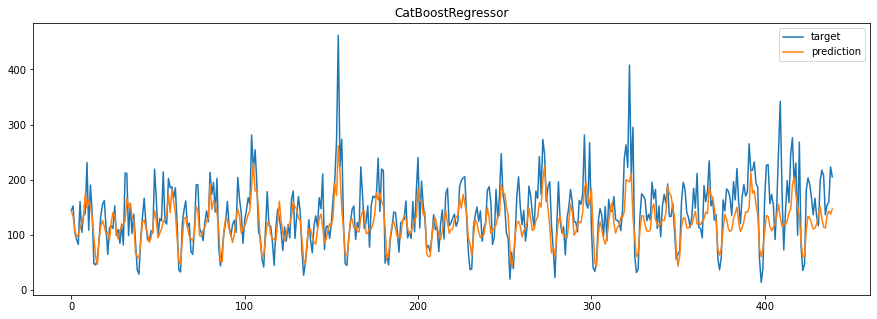

In [45]:
graph(y_test, pred_1, 'CatBoostRegressor')

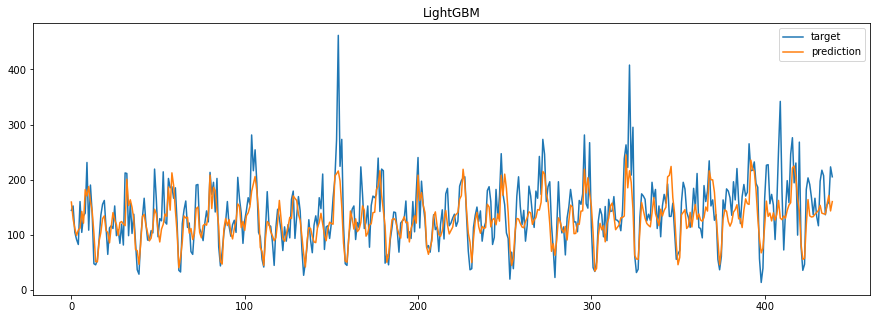

In [46]:
graph(y_test, pred_2, 'LightGBM')

Как будто к 2\3 графика предсказания начинают сильнее отличаться от таргета, но у нас и тренд начинает сильнее возрастать примерно с июля месяца. Да и ряд нестационарен, в связи с этим точность предсказаний падает.